In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy import pad
import tensorflow as tf
import pandas as pd
from model.Model import Model
from preprocess.preprocess import Dataset, PreprocessFrame, make_augments
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings("ignore")

In [2]:
# images size
img_width = 600
img_height = 100

new_img_width = 300
new_img_height = 50

batch_size = 16

# default paths
WORKING_DIR = os.path.join('/home', 'mts')
ann_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'ann')
img_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'img')
metadata = os.path.join(WORKING_DIR, 'metadata', 'metadata.tsv')

In [3]:
# collect metadata
# meta_collect(ann_path, metadata)

# get preprocessed metadata dataframe
df = PreprocessFrame(metadata=metadata,
                     img_height=img_height, img_width=img_width)

# Make augments file (if they exists: comment or delete line)
aug_df = None
aug_df = make_augments(df=df, img_path=img_path, WORKING_DIR=WORKING_DIR,
                        img_height=img_height, img_width=img_width)

# get augments metadata dataframe from original dataframe if not starting make_augments
if not isinstance(aug_df, pd.DataFrame):
    aug_df = df.copy()
    aug_df.index = aug_df.index.to_series().apply(lambda x: os.path.join('aug_1', 'aug_' + x))

train, test, val = list(Dataset(df, aug_df=aug_df,
                                test_size=0.1,
                                val_size=0.05,
                                img_path=img_path,
                                img_height=img_height,
                                img_width=img_width,
                                new_img_height=new_img_height,
                                new_img_width=new_img_width,
                                WORKING_DIR=WORKING_DIR,
                                shuffle=True,
                                random_state=12))
print(len(train), len(test), len(val))

100%|██████████| 97/97 [04:04<00:00,  2.52s/it]


5599 303 152


In [4]:
r'''
params:

callbacks: list - callback names ["checkpoint", "csv_log", "tb_log", "early_stopping"]
metrics: list - metrics name ["cer", "accuracy", "ctc_loss"]

checkpoint_path: str

csv_log_path

tb_log_path
  tb_update_freq: int

early_stopping
    early_stopping_patience: int

input_img_shape: array(width, height, 1)

vocab_len: int - len of vocab with blank 

restore_weights: bool

max_label_len: int

chars_path: str or path

blank: str - '#' in our case
'''

params = {
    'callbacks': ['checkpoint', 'csv_log', 'tb_log', 'early_stopping'],
    'metrics': ['cer', 'accuracy'],
    'checkpoint_path': os.path.join(WORKING_DIR, 'checkpoints/training_0/cp.ckpt'),
    'csv_log_path': os.path.join(WORKING_DIR, 'logs/csv_logs/log_0.csv'),
    'tb_log_path': os.path.join(WORKING_DIR, 'logs/tb_logs/log0'),
    'tb_update_freq': 200,
    'epochs': 50,
    'batch_size': batch_size,
    'restore_weights': True,
    'early_stopping_patience': 10,
    'input_img_shape': (new_img_width, new_img_height, 1),
    'vocab_len': 75,
    'max_label_len': 22,
    'chars_path': os.path.join(os.path.split(metadata)[0], 'symbols.txt'),
    'blank': '#',
    'blank_index': 74
}

In [5]:
model = Model(params)
model.build()
model.load_weights('checkpoints/training_0/cp.ckpt')

In [6]:
def show_history(history, indicators, nrows=2, ncols=2, width=15, height=10):
    _, ax = plt.subplots(nrows, ncols, figsize=(width, height))
    for i in range(min(len(indicators), nrows*ncols)):
        indicator_name = indicators[i]
        ax[i // ncols, i % ncols].plot(history[indicator_name])
        ax[i // ncols, i % ncols].plot(history['val_' + indicator_name])
        ax[i // ncols, i % ncols].set_title('Model ' + indicator_name)
        ax[i // ncols, i % ncols].set_ylabel(indicator_name)
        ax[i // ncols, i % ncols].set_xlabel('epoch')
        ax[i // ncols, i % ncols].legend(['Train', 'Val'], loc='lower left')
        
    plt.show()

In [7]:
import json
with open('history.json', 'r') as f:
    h = json.load(f)

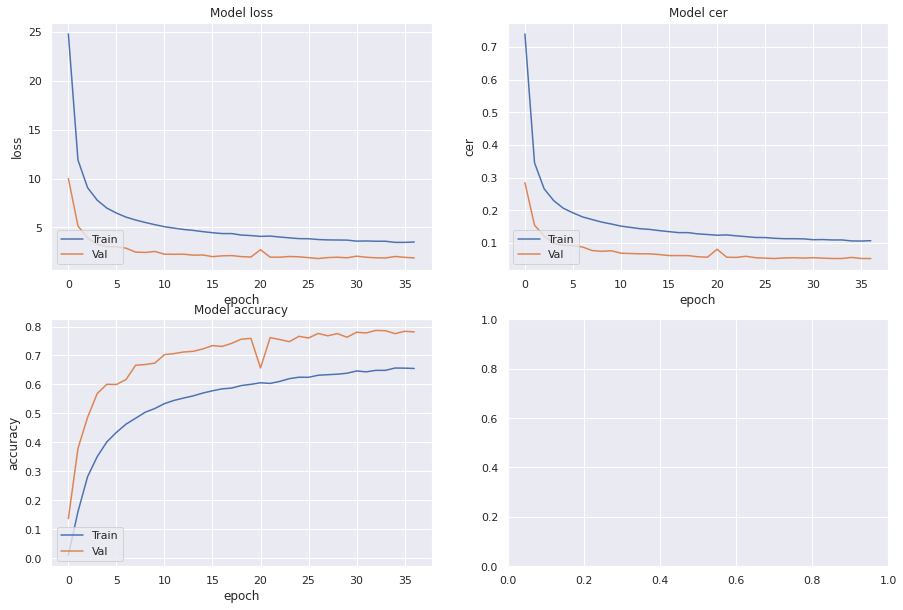

In [8]:
show_history(h, ['loss', 'cer', 'accuracy'])

In [9]:
test_metrics = model.evaluate(test)

303/303 [==============================] - 17s 52ms/step - loss: 1.6472 - cer: 0.0466 - accuracy: 0.7791


In [10]:
print(f'Метрики на тестовых данных:\n\
    ctc loss: {round(test_metrics[0], 2)}\n\
    CER: {round(test_metrics[1] * 100, 2)}%\n\
    accuracy: {round(test_metrics[2] * 100, 2)}%\n\
      ')

Метрики на тестовых данных:
    ctc loss: 1.57
    CER: 4.66%
    accuracy: 77.91%
      


In [11]:
def show_preds_on_batch(model, batch, batch_size=batch_size):
    _, ax = plt.subplots(batch_size, 1, figsize=(10, 50))

    batch_images = batch['image']
    batch_labels = batch['label']

    pred_texts = model.predict(batch)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8').replace('#', '')
        orig_texts.append(label)
    for i in range(batch_size):
        img = ((batch_images[i, :, :, 0] + 0.5) * 255).numpy().astype('uint8')
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nOriginal: {orig_texts[i]}"
        ax[i].set_title(title)
        ax[i].grid(False)
        ax[i].imshow(img, cmap="gray")

1/1 [==============================] - 1s 1s/step - loss: 1.1420 - cer: 0.0174 - accuracy: 0.8750


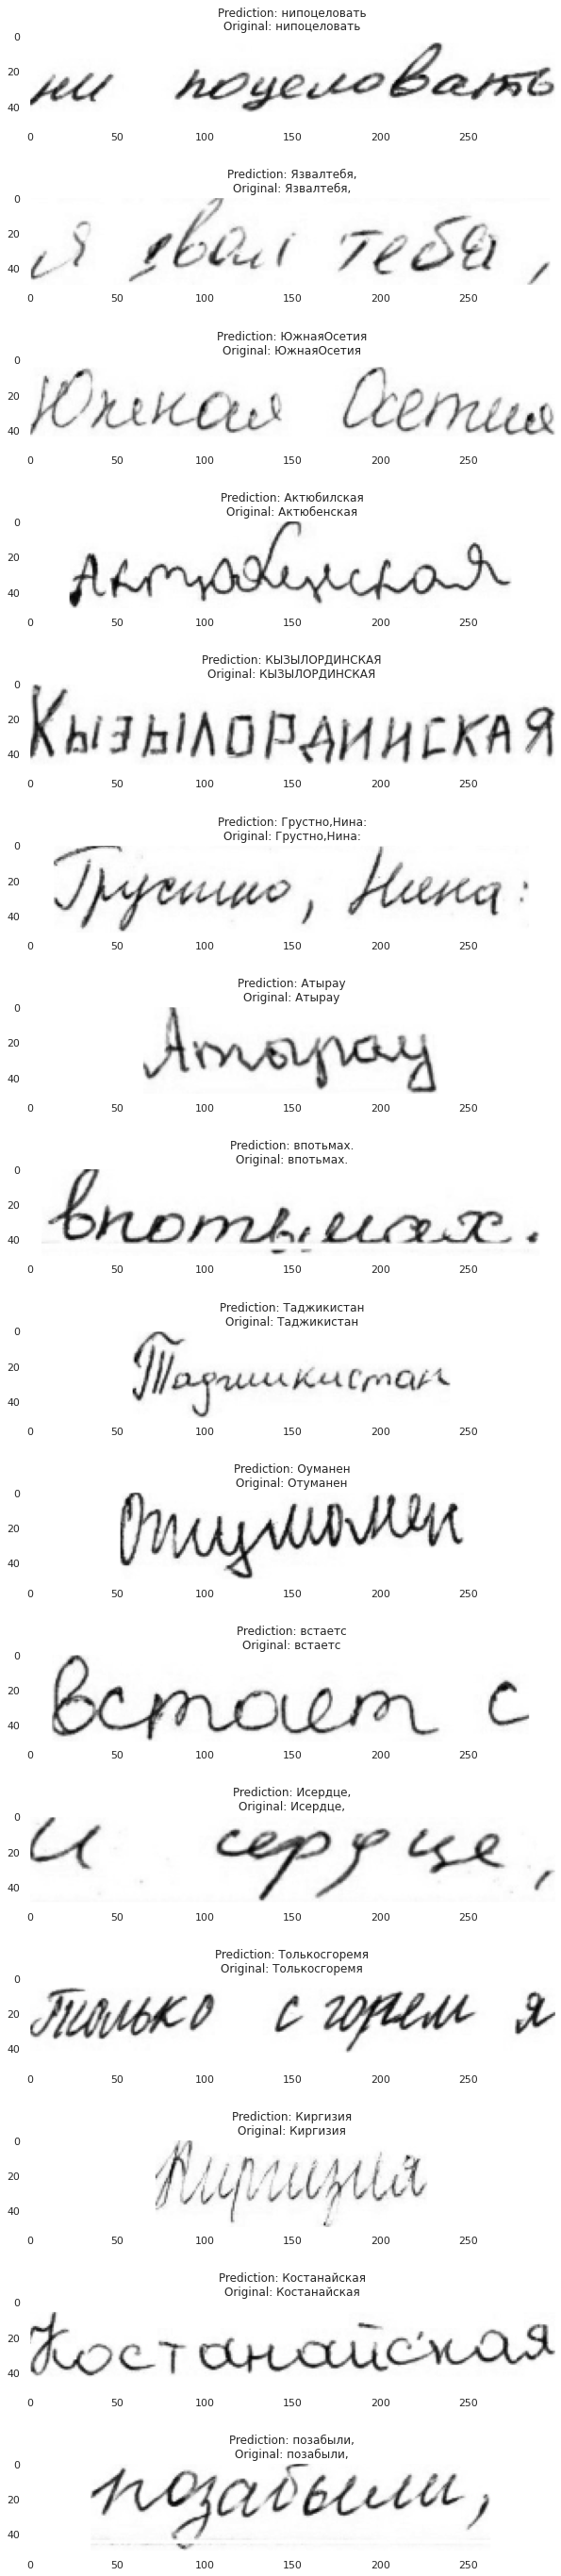

In [12]:
for batch in test.take(1):
    model.evaluate(batch)
    show_preds_on_batch(model, batch)

In [13]:
y_pred = np.empty((0, ))
y_true = np.empty((0, ))
for batch in test:
    y_pred = np.append(y_pred, model.predict(batch))
    for label in batch['label']:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8').replace('#', '')
        y_true = np.append(y_true, label)
y_comp = np.stack((y_pred, y_true), axis=-1)
y_comp

array([['нипоцеловать', 'нипоцеловать'],
       ['Язвалтебя,', 'Язвалтебя,'],
       ['ЮжнаяОсетия', 'ЮжнаяОсетия'],
       ...,
       ['Нагруди', 'Нагруди'],
       ['Затобольск', 'Затобольск'],
       ['Ноживы', 'Ноживы']], dtype='<U32')

In [14]:
vec_len = np.vectorize(len)
confusions = y_comp[(y_pred != y_true) & (vec_len(y_pred) == vec_len(y_true))]
confusions

array([['Актюбилская', 'Актюбенская'],
       ['страна', 'Страна'],
       ['неудержими,', 'неудержимо,'],
       ...,
       ['Желеннойцели', 'Желаннойцели'],
       ['гороз', 'город'],
       ['АСТАНА', 'Астана']], dtype='<U32')

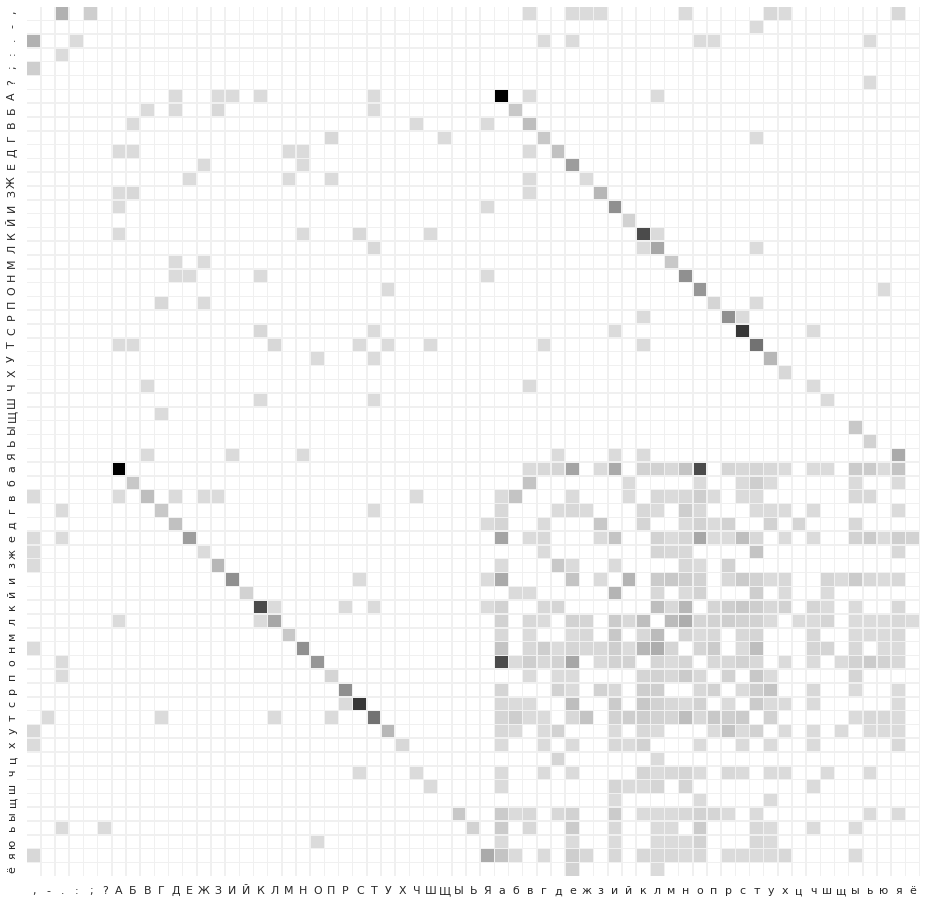

In [15]:
alphabet = set()
for pr, tr in confusions:
    for c1, c2 in zip(pr, tr):
        if c1 != c2:
            alphabet.add(c1)
            alphabet.add(c2)
alphabet = sorted(alphabet)
char_to_i = {c: i for i, c in enumerate(alphabet)}
conf_matrix = np.zeros((len(alphabet), len(alphabet)), dtype=int)
for pr, tr in confusions:
    for c1, c2 in zip(pr, tr):
        if c1 != c2:
            conf_matrix[char_to_i[c1]][char_to_i[c2]] += 1
            conf_matrix[char_to_i[c2]][char_to_i[c1]] += 1
_, ax = plt.subplots(figsize=(16, 16))
conf_matrix[conf_matrix.nonzero()] += 10 # for contrast
sns.heatmap(conf_matrix, xticklabels=alphabet, yticklabels=alphabet, ax=ax, \
            cbar=False, cmap='gray_r', linewidths=.5, linecolor='#f0f0f0')
plt.show()